In [15]:
import pandas as pd
from scipy import stats
import numpy as np
# from imblearn.over_sampling import SMOTE,SVMSMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold,StratifiedKFold,train_test_split as split
from sklearn.utils import resample, shuffle
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score,auc

from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

False

In [108]:
def load_data(csv_list): #list with elements in string
    loaded=[]
    for csv in csv_list:
        loaded.append(pd.read_csv(csv)) 
    return loaded

def preprocess(df,nan_approach,target_ordinal,drop_features):
    # data engineering tahun
    df['year_graduated']=pd.to_numeric(df['year_graduated'], errors='coerce', downcast ='integer')
# df['year_graduated'].astype('int32') #cannot convert NA or inf to integer
# keduanya dengan asumsi ini tahun 2019
    tahun_skrg=2019
    df['current_age']=tahun_skrg-df['age']
    df['years_graduated']=tahun_skrg-df['year_graduated']
    df.drop(['age','year_graduated','Education_level'],axis=1,inplace=True)
    
    # jadi ordinal
    df['job_level']=df['job_level'].str.lstrip('JG0')
    df['person_level']=df['person_level'].str.lstrip('PG0')
    df['education_level']=df['person_level'].str.lstrip('level_')
    df['job_level']=pd.to_numeric(df['job_level'], errors='raise')
    df['person_level']=pd.to_numeric(df['person_level'], errors='raise')
    df['education_level']=pd.to_numeric(df['education_level'], errors='raise')
    
    if target_ordinal == True:# achievement target
        targets=['achievement_target_1','achievement_target_2']
        for target in targets:
            df.loc[(df[target] == 'achiev_< 50%' )|( df[target] == 'Pencapaian < 50%'), target] = 1
            df.loc[(df[target] == 'achiev_50%-100%' )|( df[target] == 'Pencapaian 50%-100%'), target] = 2
            df.loc[(df[target] == 'achiev_100%-150%' )|( df[target] == 'Pencapaian 100%-150%'), target] = 3
            df.loc[(df[target] == 'achiev_> 1.5' )|( df[target] == 'Pencapaian > 1.5'), target] = 4
            df.loc[df[target] == 'Tidak diberikan target', target] = float('NaN')
            df[target]=pd.to_numeric(df[target], errors='coerce') #NaN given here
            df['achievement_target_3'] = df['achievement_target_3'].apply(lambda x: 1 if x == 'reached' else 0)
            #dibikin binernya ditentukan karena 'penting'
    
    # outliers
    angka_columns = df.loc[:, (df.dtypes == np.float64)|(df.dtypes == np.int64)].columns
    #ubah semua outliers jadi NaN (untuk nanti diubah jadi mean??)                        
    for col in angka_columns:
        z =     np.abs((df[col] - df[col].mean())/df[col].std(ddof=0))
        df.loc[z > 3, col] = float('NaN')
        
    # binary
    col = ['gender','marital_status_maried(Y/N)']
    for c in col:
        df[c] = LabelEncoder().fit_transform(df[c])

    # onehot
    col=df.select_dtypes('object').columns #all the remaining columns with object type
    for c in range(len(col)):
#             label_df = pd.DataFrame(df[col[c]], columns=[col[c]])
        dum_df = pd.get_dummies(df[col[c]], columns=[col[c]], prefix=col[c])
        df=df.join(dum_df)
        df=df.drop(col[c], axis=1)
    
    # features dropping
    if drop_features == True:
        features=['job_duration_in_current_person_level', 'job_duration_in_current_job_level', 
#                   'achievement_target_1', 'Avg_achievement_%', 'job_duration_from_dfing', 
                  'Last_achievement_%', 'job_duration_in_current_branch']
        if 'Best Performance' in df.columns:
            features.append('Best Performance')
            print('ADA BEST PERFORMANCE', df.columns)
        else:
            print('BERARTI INI TEST SOALNYA GAADA BEST PERFORMANCE')
        df = df[features]
    
    # nan management
    if (nan_approach) == 'drop':#drop
        df.dropna(subset=['job_duration_in_current_person_level', 'job_duration_in_current_job_level', 
#                           'achievement_target_1', 'Avg_achievement_%', 'job_duration_from_dfing', 
                          'Last_achievement_%', 'job_duration_in_current_branch'], how='any', inplace=True)
    elif (nan_approach) == 'mean':#mean
        df.fillna(df.mean(),inplace=True)

    return df

def split_resample(df,test_size,sampling):
    t,v = split(df,test_size=0.2, random_state=133)
    #for validation, no resampling
    X_val = v.drop('Best Performance', axis=1)
    y_val = v['Best Performance']
    
    # resampling
    df_major = t[t['Best Performance']==0]
    df_minor = t[t['Best Performance']==1]
    
    if (sampling) == 'down': #downsampling
        df_major_undersampled = resample(df_major, 
                                         replace=False,    # sample without replacement
                                         n_samples=len(df_minor),     # to match minority class
                                         random_state=133) # reproducible results
        df_undersampled = pd.concat([df_major_undersampled, df_minor])

        df_undersampled = shuffle(df_undersampled)

        X_df = df_undersampled.drop('Best Performance', axis=1)
        y_df = df_undersampled['Best Performance']

    elif (sampling) == 'up': #upsampling
        df_minor_oversampled = resample(df_minor, 
                                         replace=True,    # sample without replacement
                                         n_samples=len(df_major),     # to match minority class
        #                                  random_state=133
                                          ) # reproducible results

        df_oversampled = pd.concat([df_major, df_minor_oversampled])

        X_df = df_oversampled.drop('Best Performance', axis=1)
        y_df = df_oversampled['Best Performance']

    elif (sampling) == 'smote': #SMOTE
        X_df = t.drop('Best Performance', axis=1)
        y_df = t['Best Performance']

        sm = SVMSMOTE(random_state=133)
        X_df, y_df = sm.fit_sample(X_df, y_df)
    return X_df, y_df,X_val, y_val

def scaler(df):
    scaler = preprocessing.StandardScaler().fit(df)
    return df

def model_comparison(X_df,y_df, splits,scoring_list,refit_metric): #'roc_auc' both scoring and refit
    models = Pipeline([
        ('clf', None), 
    ])

    search = GridSearchCV(
        models, 
        cv=StratifiedKFold(n_splits=splits, shuffle=True, random_state=133), 
        scoring= scoring_list,
        refit = refit_metric, #because the model is extremely imbalanced
        n_jobs = -1,
        param_grid={
            'clf': [
                GaussianNB(),
                RandomForestClassifier(),
                LogisticRegression(max_iter=10000),
                SVC(),
                GBC(),
                ]},
        verbose=3
    )

    start = time.time()
    search.fit(X_df, y_df)
    print('total fitting time:', round((time.time() - start)/60,2), 'minute(s)')
    best_model=search.best_estimator_

    print('Best model:', search.best_params_)
    model_comparison = pd.DataFrame(search.cv_results_)
    # score= best_score_ #nanti kalo kelamaan ini komen coba
    model_comparison
    
    model_comparison['model'] = ['NB','RF','log reg','svc','gradient boost']
    ax = sns.barplot('model', 'mean_test_roc_auc', data=model_comparison, capsize=.05, palette='Reds', ci=None)
    ax.set_xlabel("Models",fontsize=12)
    ax.set_ylabel("Accuracy (%)",fontsize=12)
    ax.tick_params(labelsize=12)
    ax.axes.set_title("ROC AUC Between Models", fontsize=12)

    for p in ax.patches:
        ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=12, color='black', xytext=(0, -15),
        textcoords='offset points')
    return best_model

def predict_val(model,X_val,y_val):

    prediction_best = model.predict(X_val)
#     prediksi = best_model.predict(test)
    def confusion_matrix_heatmap(cm, index, dim):
        cmdf = pd.DataFrame(cm, index = index, columns=index)
        dims = (dim, dim)
        fig, ax = plt.subplots(figsize=dims)
        sns.heatmap(cmdf, annot=True, cmap="YlGnBu", fmt="g")

        ax.set_ylabel('Actual')    
        ax.set_xlabel('Predicted')

    print("Accuracy: ", accuracy_score(y_val, prediction_best))
    print(confusion_matrix(y_val, prediction_best))
    confusion_matrix_heatmap(confusion_matrix(y_val, prediction_best), model.classes_, 4)
    return prediction_best

def roc_auc(y_val,val_prediction):
    ns_probs = [1 for _ in range(len(y_val))] #random guessing
    # calculate scores
    ns_auc = roc_auc_score(y_val, ns_probs)
    lr_auc = roc_auc_score(y_val, val_prediction)
    # summarize scores
    print('Model s ROC from validation: ROC AUC = %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_val, val_prediction)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Best Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.figure(figsize=(10,10))
    plt.legend()
    plt.show()

def predict(df,model,csv_output):
#     prediction = model.predict(test)
    prediction = model.predict_proba(test)#wow untung dikasi tau jeri uda bukan 1 0
    print(prediction)
    prediction_df = pd.DataFrame()
    prediction_df['index']=range(0,len(prediction))
    prediction_df['Best Performance']=[i[1] for i in prediction]
    
    prediction_df.to_csv('submissions/'+str(csv_output)+'.csv', index=False)
    return prediction_df

ADA BEST PERFORMANCE Index(['job_level', 'job_duration_in_current_job_level', 'person_level',
       'job_duration_in_current_person_level',
       'job_duration_in_current_branch', 'gender',
       'marital_status_maried(Y/N)', 'number_of_dependences', 'GPA',
       'job_duration_from_training', 'branch_rotation', 'job_rotation',
       'assign_of_otherposition', 'annual leave', 'sick_leaves',
       'Last_achievement_%', 'Achievement_above_100%_during3quartal',
       'Best Performance', 'current_age', 'years_graduated', 'education_level',
       'Employee_type_RM_type_A', 'Employee_type_RM_type_B',
       'Employee_type_RM_type_C'],
      dtype='object')
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


total fitting time: 0.03 minute(s)
Best model: {'clf': GradientBoostingClassifier()}
Accuracy:  0.5297245045915902
[[910 818]
 [155 186]]


D:\Program Files\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Model s ROC from validation: ROC AUC = 0.536


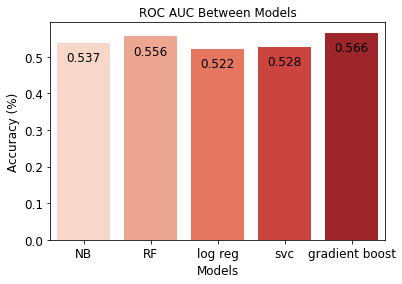

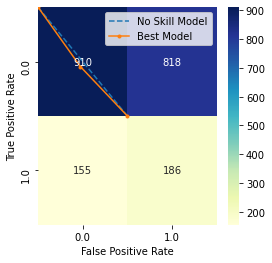

BERARTI INI TEST SOALNYA GAADA BEST PERFORMANCE
[[0.59311061 0.40688939]
 [0.43858552 0.56141448]
 [0.62637809 0.37362191]
 ...
 [0.31513355 0.68486645]
 [0.59029334 0.40970666]
 [0.49726332 0.50273668]]


,index,Best Performance
0,0,0.406889
1,1,0.561414
2,2,0.373622
3,3,0.242852
4,4,0.519783
...,...,...
5995,5995,0.510310
5996,5996,0.445307
5997,5997,0.684866
5998,5998,0.409707


In [110]:
train,test = load_data(['train.csv','test.csv'])
train = preprocess(train,nan_approach='drop',target_ordinal=False #target ordinal belom dicek di dataset baru
                   , drop_features=True)

X_train, y_train,X_val, y_val = split_resample(train,0.2,'down')
# X_train,X_val = scaler([X_train,X_val])
X_train,X_val = scaler(X_train),scaler(X_val)

model=model_comparison(X_train,y_train,3,['roc_auc'],'roc_auc')
val_predicted = predict_val(model,X_val,y_val)
roc_auc(y_val,val_predicted)

test = preprocess(test,nan_approach='mean',target_ordinal=False #target ordinal belom dicek di dataset baru
                   , drop_features=True)
test = scaler(test)

predict(test,model,'coba2_inikeren_proba')

KeyError: "['achievement_target_1', 'Avg_achievement_%', 'job_duration_from_dfing'] not in index"

